In [23]:
from train import config as defaults
from kbgen.model import KBFormer, mup_model
from kbgen.model.modules import _ResBlock
import torch
from kbgen.utils import Fields, TensorDict
import tqdm
from matplotlib import pyplot as plt
import mup
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(1, 2))

test_fields = Fields(
            # numerical=[],
            numerical=["dummy"],
            categorical=["dummy_cat"],
            # categorical=[],
            text=[],
        )
defaults["fields"] = test_fields
defaults["num_emb"] = "dice"
defaults["tie_numerical_embeddings"] = True
defaults["tie_embeddings"] = True
defaults["num_target_scalar"] = True
defaults["d_model"] = 256
print(defaults)

{'d_model': 256, 'nhead': 2, 'num_layers': 1, 'field_encoder_layers': 2, 'field_decoder_layers': 2, 'text_decoder_layers': 1, 'text_encoder_layers': 1, 'num_emb': 'dice', 'tie_embeddings': True, 'tie_numerical_embeddings': True, 'num_target_scalar': True, 'epochs': 10000, 'batch_size': 4096, 'lr': 0.0001, 'weight_decay': 0, 'dropout': 0.0, 'mask_rate': (0.1, 0), 'wandb': False, 'tags': ['test'], 'device': 'cuda:0', 'seed': 42, 'num_fields': 13, 'vocab_size': 7536, 'fields': Fields([('numerical', ['dummy']), ('categorical', ['dummy_cat']), ('text', [])]), 'rootdir': '/home/user/logdir'}


In [24]:
# input_dict = TensorDict({"dummy": torch.arange(10),
#                                 "dummy_cat": torch.arange(10) % 5,
#                                 }, fields=test_fields)
# print("This is what a tensor_dict looks like\n", input_dict)
# # initialize a model
# torch.manual_seed(defaults["seed"])
# model = mup_model(KBFormer, {"d_model": defaults["d_model"]}, defaults)
# # let's embed the dummy field
# emb_dict = model.embed_properties(input_dict)
# print("\nThis is the shape for the embedding of the dummy variable\n", emb_dict["dummy"].shape)
# preds, targets = model(input_dict)
# print("\nThis is the output of the model\n", preds, targets)

In [25]:
# import pandas as pd
# from kbgen.data.datasets import GSM
# from kbgen.utils.log import rootdir
# dataset = GSM(rootdir + "/data/gsm")
# dataset.df[dataset.fields["numerical"]].replace("<pad>", np.nan).max()
# df = dataset.df.replace("<pad>", np.nan).to_dict(orient="series")
# dummy = df.pop("<dummy>")
# df = dataset.reverse_transform(df)
# df["<dummy>"] = dummy
# df = pd.DataFrame(df)
# df = df[dataset._df.columns]
# dataset._df == df
# df["phone.display_size"].values, dataset._df["phone.display_size"].values

In [26]:
torch.manual_seed(defaults["seed"])
n_samples = 1000
X = np.linspace(1940, 2010, n_samples)
X = scaler.fit_transform(X.reshape(-1, 1))
X = torch.tensor(X).float().view(-1)
X = X[torch.randperm(n_samples)]
X_train = X[:int(n_samples * 0.8)]
X_test = X[int(n_samples * 0.8):]
cat_train = torch.randint(0, 5, (int(n_samples * 0.8),))
cat_test = torch.randint(0, 5, (int(n_samples * 0.2),))
input_dict = TensorDict({"dummy": X_train,
                                "dummy_cat": cat_train,
                                }, fields=test_fields)

torch.manual_seed(defaults["seed"])
model = mup_model(KBFormer, {"d_model": defaults["d_model"]}, defaults)

In [27]:
# # train categorical
# for _ in (pbar:=tqdm.trange(1000)):
#     preds, targets = model(input_dict)
#     losses = {}
#     for field in defaults["fields"]["categorical"]:
#         target = targets[field]
#         pred = preds[field]
#         losses[field] = torch.nn.functional.cross_entropy(pred, target)
#     loss:torch.Tensor = sum(losses.values()) # type: ignore
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     with torch.no_grad():
#         acc = (pred.argmax(dim=-1) == target).float().mean()
#     pbar.set_description(f"Loss: {loss.item():.3f}, Acc: {acc.item():.3f}")


In [28]:
# x = torch.linspace(0, 100, 1000)
# test_token_dict = TensorDict({"dummy": x, "dummy_cat" : x.long()%6}, fields=test_fields)
# mask = torch.zeros(len(x), 2)
# mask[:, 0] = -torch.inf
# preds, targets = model(test_token_dict, property_mask=mask)
# (preds["dummy_cat"].argmax(-1) == targets["dummy_cat"]).float().mean()

In [29]:
for name, p in model.named_parameters():
    if p.grad is None:
        continue
    print(name, p.shape, p.view(-1)[:3], p.grad.view(-1)[:3])
    break

In [51]:
torch.arange(10, dtype=float).view(-1, 1).norm(dim=-1)

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], device='cuda:0',
       dtype=torch.float64)

In [38]:
optimizer = mup.MuAdamW(model.parameters(), lr=1e-5, weight_decay=0)
for _ in (pbar:=tqdm.trange(1000)):
    preds, targets = model(input_dict)
    losses = {}
    for field in defaults["fields"]["numerical"]:
        target = targets[field].float().view(-1, 1)
        norm = target.norm(dim=-1) + 1e-6
        pred = preds[field]
        losses[field] = ((pred - target)/norm).pow(2).mean().sqrt()/10
    for field in defaults["fields"]["categorical"]:
        target = targets[field]
        pred = preds[field]
        losses[field] = torch.nn.functional.cross_entropy(pred, target)
    loss:torch.Tensor = sum(losses.values())/len(losses) # type: ignore
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    pbar.set_description(" | ".join([f"{k} {v.item()*100:^5.2f}" for k, v in losses.items()]))

dummy 0.01  | dummy_cat 0.00 :   1%|          | 6/1000 [00:00<00:17, 55.88it/s]

dummy 0.01  | dummy_cat 0.00 : 100%|██████████| 1000/1000 [00:17<00:00, 57.84it/s]


In [31]:
mlp = torch.nn.Sequential(
    _ResBlock(defaults["d_model"]),
    mup.MuReadout(defaults["d_model"], 1),
)
mup.set_base_shapes(mlp, mlp)

Sequential(
  (0): _ResBlock(
    (linear1): Linear(in_features=256, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (1): MuReadout(in_features=256, out_features=1, bias=True)
)

In [32]:
optimizer_mlp = mup.AdamW(mlp.parameters(), lr=1e-4, weight_decay=0)
for _ in (pbar:=tqdm.trange(1000)):
    embs = model.embed_properties(input_dict)
    pred = mlp(embs["dummy"])
    target = input_dict["dummy"].float().view(-1, 1)
    norm = target.norm(dim=-1) + 1e-6
    loss = ((pred - target)/norm).pow(2).mean().sqrt()
    optimizer_mlp.zero_grad()
    loss.backward()
    optimizer_mlp.step()
    pbar.set_description(f"Loss: {loss.item() * 100 :.2f}")

Loss: 2.45:   0%|          | 27/10000 [00:00<00:37, 267.89it/s] 

Loss: 0.18: 100%|██████████| 10000/10000 [00:31<00:00, 318.37it/s]


In [33]:
x, sort = X_test.sort()
test_token_dict = TensorDict({"dummy": x, "dummy_cat" : cat_test[sort]}, fields=test_fields)

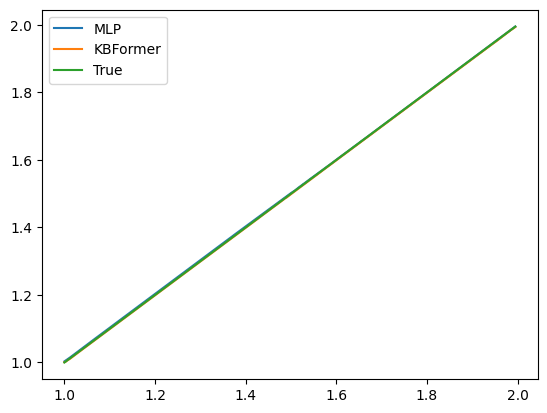

In [39]:
embs = model.embed_properties(test_token_dict)
y = mlp(embs["dummy"]).cpu().detach()
preds, tgts = model(test_token_dict)# type: ignore
y_model = preds["dummy"].cpu().detach()
plt.plot(x.cpu(), y, label="MLP")
plt.plot(x.cpu(), y_model, label="KBFormer")
plt.plot(x.cpu(), x.cpu(), label="True")
plt.legend()

dummy acc: 99.9251748318784 %
cat acc 100.0 %


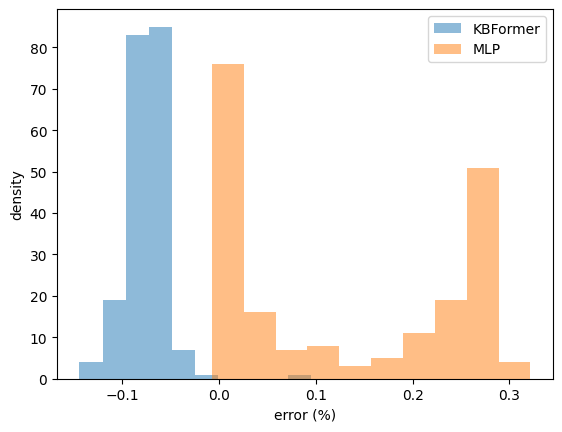

In [41]:
p = preds["dummy"].detach().cpu().view(-1)
t = tgts["dummy"].detach().cpu().view(-1, 1)
p_mlp = mlp(embs["dummy"]).detach().cpu().view(-1)
norm = t.norm(dim=-1) + 1e-6
t = t.view(-1)
plt.hist((p-t)/norm * 100, alpha=0.5, label="KBFormer")
plt.hist((p_mlp-t)/norm * 100, alpha=0.5, label="MLP")
plt.legend()
plt.ylabel("density")
plt.xlabel("error (%)")
print("dummy acc:", 100 - ((p-t)/norm).abs().mean().item()*100, "%")
print("cat acc", (preds["dummy_cat"].argmax(-1) == tgts["dummy_cat"]).float().mean().item()*100, "%")